# Qiskit implementation

In [1]:
import qiskit
import numpy as np

print (f"__version__: {qiskit.__version__}")

from qiskit import transpile, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
%matplotlib inline

__version__: 0.18.3


In [2]:
qr = QuantumRegister(3, name="q")

crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")

answer = ClassicalRegister(1, name="answer")

In [3]:
qc = QuantumCircuit(qr, crz, crx, answer)

In [4]:
qc.ry(np.pi/2, 0)  # Set qubit to the |+⟩ state
#qc.ry(-np.pi/2, 0) # Set qubit to the |-⟩ state

# Measurement in the Hadamard basis
# qc.h(qr[0])
# qc.measure(qr[0], answer)  

# Step 1
qc.h(qr[1])

# Step 2
qc.cx(qr[1], qr[2])

# Step 3
qc.cx(qr[0], qr[1])

# Step 4
qc.h(qr[0])

# Step 5 - Alice's measurements
qc.measure(qr[0], crz)
qc.measure(qr[1], crx)

# Step 6 - Bob's conditional X/Z gates
qc.x(qr[2]).c_if(crx, 1)
qc.z(qr[2]).c_if(crz, 1)

# Measurement in the Hadamard basis
qc.h(qr[2])
qc.measure(qr[2], answer)

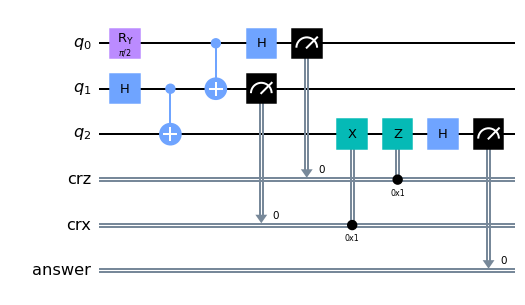

In [5]:
qc.draw(output="mpl")

## Simulation

In [6]:
simulator = QasmSimulator()

compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=100000)

result = job.result()
counts = result.get_counts(compiled_circuit)
print (counts)

{'0 0 1': 24989, '0 0 0': 24971, '0 1 1': 24852, '0 1 0': 25188}


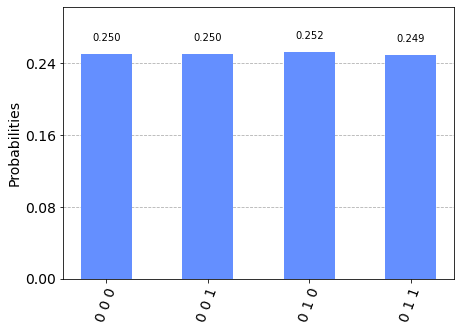

In [7]:
plot_histogram(counts)

# PennyLane implementation

In [8]:
import pennylane as qml
import pandas as pd
from pennylane import numpy as np

In [9]:
device = qml.device('default.qubit', shots=None, wires=3)

@qml.qnode(device)
def circuit(sign):
    
    # Set qubit to the |+⟩ or |-⟩ state
    qml.RY(sign * np.pi/2, wires=0)
        
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=0)
    
    # Measurement in the Hadamard basis
    qml.Hadamard(wires=2)
    return qml.probs(wires=[0,1,2])

probs_0 = circuit(1.0)
print (circuit.draw())
print (f"probs_0: {np.round(probs_0,6)}")

 0: ──RY(1.57)──────╭C──H──╭┤ Probs 
 1: ──H─────────╭C──╰X─────├┤ Probs 
 2: ────────────╰X───H─────╰┤ Probs 

probs_0: [0.25 0.   0.25 0.   0.   0.25 0.   0.25]


In [10]:
device = qml.device('default.qubit', shots=None, wires=3)

@qml.qnode(device)
def circuit(sign):
    
    # Set qubit to the |+⟩ or |-⟩ state
    qml.RY(sign * np.pi/2, wires=0)
        
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=0)
    
    # Measurement in the Hadamard basis
    qml.Hadamard(wires=2)
    return qml.probs(wires=[0,1,2])

probs_1 = circuit(-1.0)
print (circuit.draw())
print (f"probs_1: {np.round(probs_1,6)}")

 0: ──RY(-1.57)──────╭C──H──╭┤ Probs 
 1: ──H──────────╭C──╰X─────├┤ Probs 
 2: ─────────────╰X───H─────╰┤ Probs 

probs_1: [0.   0.25 0.   0.25 0.25 0.   0.25 0.  ]


In [11]:
ds = pd.DataFrame()
ds[0] = np.arange(8) // 4 % 2
ds[1] = np.arange(8) // 2 % 2
ds[2] = np.arange(8) // 1 % 2
ds['probs_0'] = probs_0.round(6)
ds['probs_1'] = probs_1.round(6)
ds

,0,1,2,probs_0,probs_1
0,0,0,0,0.25,0.00
1,0,0,1,0.00,0.25
2,0,1,0,0.25,0.00
3,0,1,1,0.00,0.25
4,1,0,0,0.00,0.25
5,1,0,1,0.25,0.00
6,1,1,0,0.00,0.25
7,1,1,1,0.25,0.00


In [12]:
ds[ds['probs_0'] > 0][[0,1,2]]

,0,1,2
0,0,0,0
2,0,1,0
5,1,0,1
7,1,1,1


### If we loose upper qubit (Z) measurement, then everything is lost: |+⟩ and |-⟩ are indistinguishable

In [13]:
ds_0 = ds[ds['probs_0'] > 0][[0,1,2]].copy()
ds_0['value'] = 0
ds_1 = ds[ds['probs_1'] > 0][[0,1,2]].copy()
ds_1['value'] = 1
tmp = pd.concat([ds_0,ds_1]).reset_index(drop=True)
tmp.groupby([1,2])['value'].mean().reset_index()

,1,2,value
0,0,0,0.5
1,0,1,0.5
2,1,0,0.5
3,1,1,0.5


### If we loose middle qubit (X) measurement, then we can distinguish  |+⟩ and |-⟩

In [14]:
ds_0 = ds[ds['probs_0'] > 0][[0,1,2]].copy()
ds_0['value'] = 0
ds_1 = ds[ds['probs_1'] > 0][[0,1,2]].copy()
ds_1['value'] = 1
tmp = pd.concat([ds_0,ds_1]).reset_index(drop=True)
tmp.groupby([0,2])['value'].mean().reset_index()

,0,2,value
0,0,0,0.0
1,0,1,1.0
2,1,0,1.0
3,1,1,0.0
